In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import mne
import pathlib
import scipy
import tqdm
import random
from sklearn.decomposition import PCA

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../src/utils/')
from format_hbn import HBNFormatter
from transforms import _compose, _randomcrop, totensor, \
channelwide_norm, channelwise_norm, _clamp, toimshape
from functools import partial

clamp = partial(_clamp, dev_val=20)

### Interface with data

In [3]:
hbn_data_dir = pathlib.Path("/data0/practical-sose23/brain-age/data/hbn/unzipped/rest")
bap_data_dir = pathlib.Path("/data0/practical-sose23/brain-age/data/bap/raw/")

assert hbn_data_dir.is_dir()
assert bap_data_dir.is_dir()

In [4]:
eeg_files_hbn = list(hbn_data_dir.rglob("RestingState.mat"))
eeg_files_bap = list(bap_data_dir.rglob("*.vhdr"))
eeg_files_bap = [f for f in eeg_files_bap if "preprocessed" in str(f)]

random.seed(42)
random.shuffle(eeg_files_hbn)
random.shuffle(eeg_files_bap)

In [5]:
def get_subj_id(eeg_file: pathlib.Path):
    return eeg_file.stem.split("_")[-3]

def get_age(df_subj, eeg_file: pathlib.Path):
    subj_id = get_subj_id(eeg_file)
    return df_subj[df_subj["Subject ID"] == subj_id]["Age(years)"].values[0]

### Set preprocessing parameters

In [6]:
sfreq = int(135) # sfreq
l_freq = 1.0
h_freq = 45.0 # sfreq//(1+2)

n_files = 8
interpolation_control = False #shuffle the interpolation matrix to see if data drift gets worse

### Set-up interpolation method

In [7]:
example_raw = mne.io.read_raw_brainvision(eeg_files_bap[0], verbose=False, preload=True)
channel_to_channel_type = {ch_name:"eeg" for ch_name in example_raw.ch_names}
channel_to_channel_type.update({"LE":"misc", "RE":"misc"})
eeg_chs_bap = [ch for ch in example_raw.ch_names if not (ch=="RE" or ch=="LE")]

/tmp/ipykernel_121860/1499710114.py:1: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  example_raw = mne.io.read_raw_brainvision(eeg_files_bap[0], verbose=False, preload=True)
/tmp/ipykernel_121860/1499710114.py:1: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'T

### Adjust hbn montage

In [100]:
montage_bap = mne.channels.make_standard_montage("standard_1020")
montage_hbn_df = pd.read_csv(hbn_data_dir.parent.parent / "raw" / "GSN_HydroCel_129.tsv", sep="\t", header=None)

ch_pos_bap = montage_bap.get_positions()["ch_pos"]
pos_bap = np.array([xyz for xyz in ch_pos_bap.values()])

min_dist_bap = np.linalg.norm(pos_bap, axis=1).min()
max_dist_bap = 0.75*np.linalg.norm(pos_bap, axis=1).max()
min_dist_hbn = np.linalg.norm(montage_hbn_df.iloc[:, 1:].values, axis=1).min()
max_dist_hbn = np.linalg.norm(montage_hbn_df.iloc[:, 1:].values, axis=1).max()

# max_dist_bap = pos_bap.mean(axis=0)
# max_dist_hbn = montage_hbn_df.iloc[:, 1:].values.mean(axis=0)

montage_hbn_df.iloc[:, 1:] = montage_hbn_df.iloc[:, 1:].apply(lambda x:x/(max_dist_hbn/(max_dist_bap))) 
# montage_hbn_df.iloc[:, 1].apply(lambda x:x/(max_dist_hbn/max_dist_bap)[0]) 
# montage_hbn_df.iloc[:, 2].apply(lambda x:x/(max_dist_hbn/max_dist_bap)[1]) 
# montage_hbn_df.iloc[:, 3].apply(lambda x:x/(max_dist_hbn/max_dist_bap)[2]) 

montage_hbn_df.to_csv(hbn_data_dir.parent.parent / "raw" / "GSN_HydroCel_129.csv", index=False)
montage_hbn = mne.channels.read_custom_montage(
    hbn_data_dir.parent.parent / "raw" / "GSN_HydroCel_129.csv"
)

montage_hbn.plot(),
montage_bap.plot()

### Set up formatting function

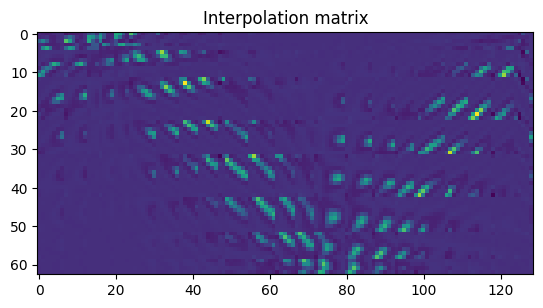

In [102]:
format_hbn = HBNFormatter(
    channel_names_bap=eeg_chs_bap,
    montage_bap=montage_bap,
    montage_hbn=montage_hbn, 
    interpolation=True
)


if interpolation_control:
    np.random.seed(42)
    plt.title("Interpolation matrix: pre shuffling")
    plt.imshow(format_hbn.interpolate.interpolation_matrix)
    plt.show()
    np.random.shuffle(format_hbn.interpolate.interpolation_matrix)
    plt.title("Interpolation matrix: post shuffling")
    plt.imshow(format_hbn.interpolate.interpolation_matrix)
    plt.show()
else:
    plt.title("Interpolation matrix")
    plt.imshow(format_hbn.interpolate.interpolation_matrix)
    plt.show()

In [103]:
def format_hbn_to_bap(mat_file, interpolate_to_common, chs_in_bap, montage_bap):
    ## Load the .mat file
    mat_struct = scipy.io.loadmat(mat_file)
    
    ## organize the meta data
    raw_data = mat_struct["EEG"]["data"][0][0]
    fs = mat_data["EEG"]["srate"]
    ch_types = len(chs_in_bap)*["eeg"]
    info = mne.create_info(ch_names=chs_in_bap, sfreq=fs, ch_types=ch_types)
    info.set_montage(montage_bap)
    
    ## interpolate channels of bap from hbn
    raw_data = interpolate_to_common(raw_data)
    
    return mne.io.RawArray(raw_data, info)

### Preprocess both file types

  0%|                                                                                                                  | 0/8 [00:00<?, ?it/s]

Creating RawArray with float64 data, n_channels=129, n_times=185785
    Range : 0 ... 185784 =      0.000 ...   371.568 secs
Ready.


/u/home/swth/brain-age/drafts/schwarz/../../src/utils/format_hbn.py:65: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info.set_montage(self.montage_hbn)


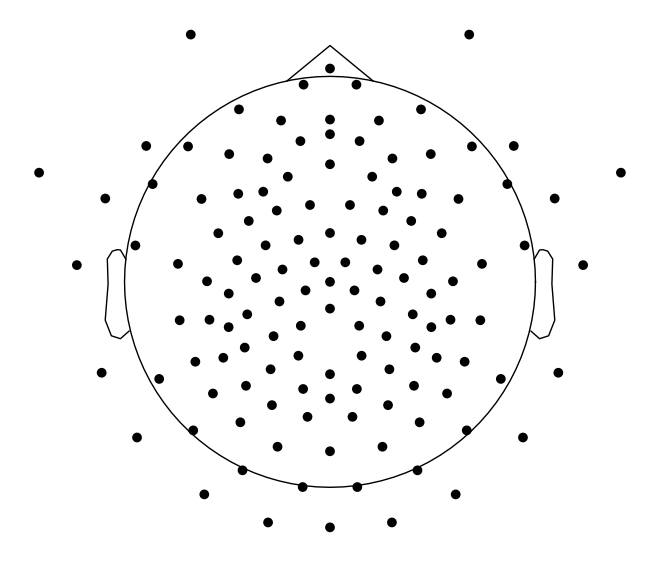

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    0.5s finished


Executing RANSAC
This may take a while, so be patient...
Progress: 10%... 20%... 30%... 40%... 50%... 60%... 70%... 80%... 90%... 100%

RANSAC done!
Interpolating bad channels
    Automatic origin fit: head of radius 78.3 mm
Computing interpolation matrix from 109 sensor positions
Interpolating 20 sensors
Creating RawArray with float64 data, n_channels=63, n_times=185785
    Range : 0 ... 185784 =      0.000 ...   371.568 secs
Ready.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.25
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.00 Hz)
- Upper passband edge: 50.75 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 51.00 Hz)
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)



[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.2s finished


Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 31 events and 1350 original time points ...
0 bad epochs dropped
Effective window size : 5.000 (s)


 12%|█████████████▎                                                                                            | 1/8 [00:37<04:25, 37.89s/it]

Creating RawArray with float64 data, n_channels=129, n_times=224030
    Range : 0 ... 224029 =      0.000 ...   448.058 secs
Ready.


/u/home/swth/brain-age/drafts/schwarz/../../src/utils/format_hbn.py:65: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info.set_montage(self.montage_hbn)


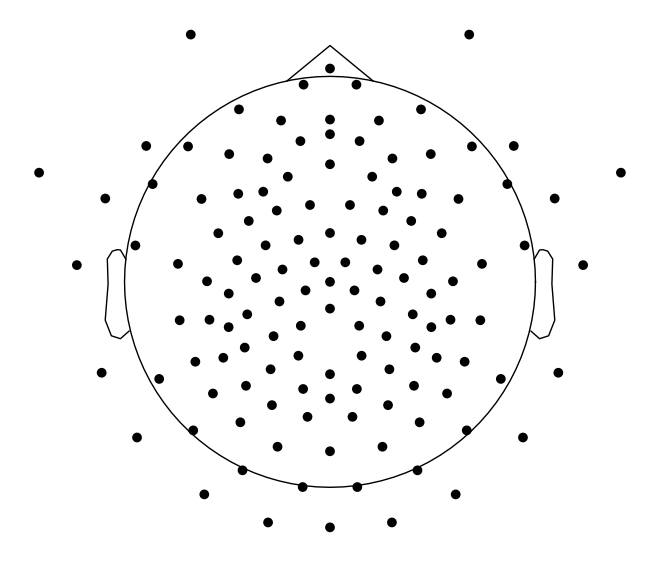

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    0.6s finished


Executing RANSAC
This may take a while, so be patient...
Progress: 10%... 20%... 30%... 40%... 50%... 60%... 70%... 80%... 90%... 100%

RANSAC done!
Interpolating bad channels
    Automatic origin fit: head of radius 78.3 mm
Computing interpolation matrix from 107 sensor positions
Interpolating 22 sensors
Creating RawArray with float64 data, n_channels=63, n_times=224030
    Range : 0 ... 224029 =      0.000 ...   448.058 secs
Ready.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.25
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.00 Hz)
- Upper passband edge: 50.75 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 51.00 Hz)
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)



[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.3s finished


Not setting metadata
38 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 38 events and 1350 original time points ...
0 bad epochs dropped
Effective window size : 5.000 (s)


 25%|██████████████████████████▌                                                                               | 2/8 [01:22<04:09, 41.60s/it]

Creating RawArray with float64 data, n_channels=129, n_times=190996
    Range : 0 ... 190995 =      0.000 ...   381.990 secs
Ready.


/u/home/swth/brain-age/drafts/schwarz/../../src/utils/format_hbn.py:65: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info.set_montage(self.montage_hbn)


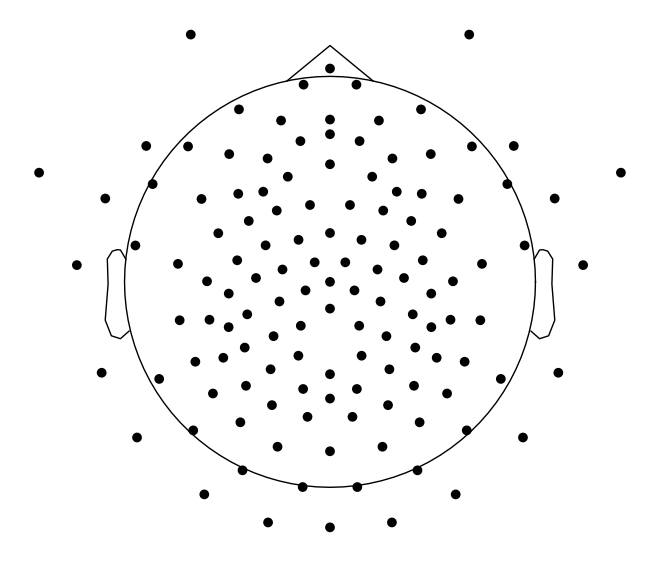

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    0.6s finished


Executing RANSAC
This may take a while, so be patient...
Progress: 10%... 20%... 30%... 40%... 50%... 60%... 70%... 80%... 90%... 100%

RANSAC done!
Interpolating bad channels
    Automatic origin fit: head of radius 78.3 mm
Computing interpolation matrix from 104 sensor positions
Interpolating 25 sensors
Creating RawArray with float64 data, n_channels=63, n_times=190996
    Range : 0 ... 190995 =      0.000 ...   381.990 secs
Ready.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.25
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.00 Hz)
- Upper passband edge: 50.75 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 51.00 Hz)
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)



[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.3s finished


Not setting metadata
32 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 32 events and 1350 original time points ...
0 bad epochs dropped
Effective window size : 5.000 (s)


 38%|███████████████████████████████████████▊                                                                  | 3/8 [01:55<03:08, 37.78s/it]

Creating RawArray with float64 data, n_channels=129, n_times=175537
    Range : 0 ... 175536 =      0.000 ...   351.072 secs
Ready.


/u/home/swth/brain-age/drafts/schwarz/../../src/utils/format_hbn.py:65: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info.set_montage(self.montage_hbn)


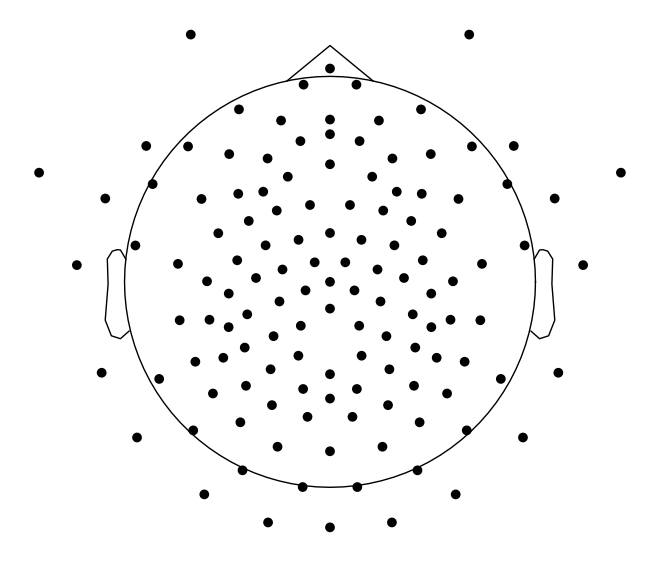

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    0.6s finished


Executing RANSAC
This may take a while, so be patient...
Progress: 10%... 20%... 30%... 40%... 50%... 60%... 70%... 80%... 90%... 100%

RANSAC done!
Interpolating bad channels
    Automatic origin fit: head of radius 78.3 mm
Computing interpolation matrix from 111 sensor positions
Interpolating 18 sensors
Creating RawArray with float64 data, n_channels=63, n_times=175537
    Range : 0 ... 175536 =      0.000 ...   351.072 secs
Ready.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.25
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.00 Hz)
- Upper passband edge: 50.75 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 51.00 Hz)
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)



[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.2s finished


Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 29 events and 1350 original time points ...
0 bad epochs dropped
Effective window size : 5.000 (s)


 50%|█████████████████████████████████████████████████████                                                     | 4/8 [02:31<02:28, 37.01s/it]

Creating RawArray with float64 data, n_channels=129, n_times=175709
    Range : 0 ... 175708 =      0.000 ...   351.416 secs
Ready.


/u/home/swth/brain-age/drafts/schwarz/../../src/utils/format_hbn.py:65: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info.set_montage(self.montage_hbn)


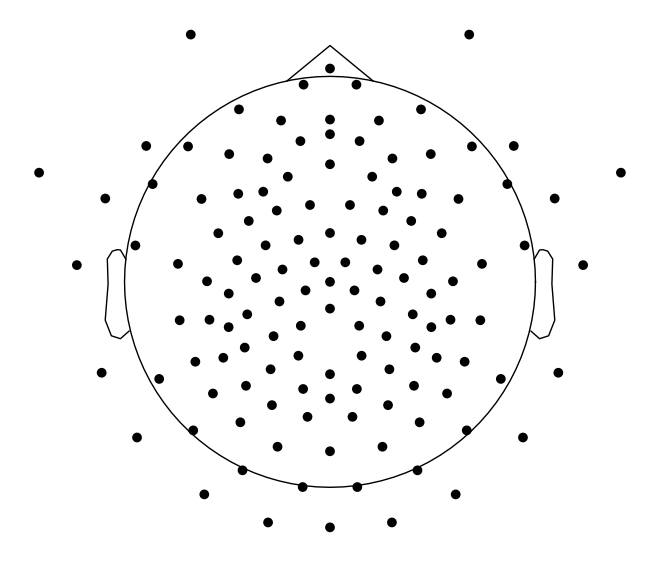

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    0.6s finished


Executing RANSAC
This may take a while, so be patient...
Progress: 10%... 20%... 30%... 40%... 50%... 60%... 70%... 80%... 90%... 100%

RANSAC done!
Interpolating bad channels
    Automatic origin fit: head of radius 78.3 mm
Computing interpolation matrix from 120 sensor positions
Interpolating 9 sensors
Creating RawArray with float64 data, n_channels=63, n_times=175709
    Range : 0 ... 175708 =      0.000 ...   351.416 secs
Ready.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.25
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.00 Hz)
- Upper passband edge: 50.75 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 51.00 Hz)
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)



[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.2s finished


Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 29 events and 1350 original time points ...
0 bad epochs dropped
Effective window size : 5.000 (s)


 62%|██████████████████████████████████████████████████████████████████▎                                       | 5/8 [03:06<01:48, 36.30s/it]

Creating RawArray with float64 data, n_channels=129, n_times=175759
    Range : 0 ... 175758 =      0.000 ...   351.516 secs
Ready.


/u/home/swth/brain-age/drafts/schwarz/../../src/utils/format_hbn.py:65: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info.set_montage(self.montage_hbn)


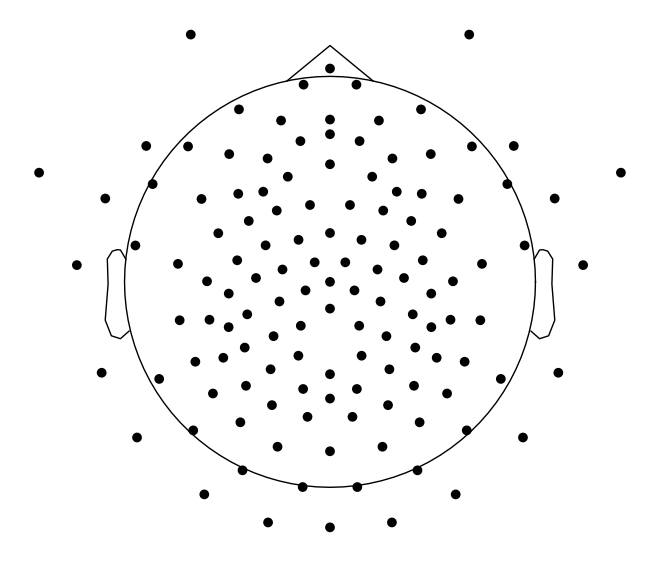

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    0.5s finished


Executing RANSAC
This may take a while, so be patient...
Progress: 10%... 20%... 30%... 40%... 50%... 60%... 70%... 80%... 90%... 100%

RANSAC done!
Interpolating bad channels
    Automatic origin fit: head of radius 78.3 mm
Computing interpolation matrix from 111 sensor positions
Interpolating 18 sensors
Creating RawArray with float64 data, n_channels=63, n_times=175759
    Range : 0 ... 175758 =      0.000 ...   351.516 secs
Ready.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.25
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.00 Hz)
- Upper passband edge: 50.75 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 51.00 Hz)
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)



[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.2s finished


Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 29 events and 1350 original time points ...
0 bad epochs dropped
Effective window size : 5.000 (s)


 75%|███████████████████████████████████████████████████████████████████████████████▌                          | 6/8 [03:41<01:12, 36.03s/it]

Creating RawArray with float64 data, n_channels=129, n_times=262609
    Range : 0 ... 262608 =      0.000 ...   525.216 secs
Ready.


/u/home/swth/brain-age/drafts/schwarz/../../src/utils/format_hbn.py:65: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info.set_montage(self.montage_hbn)


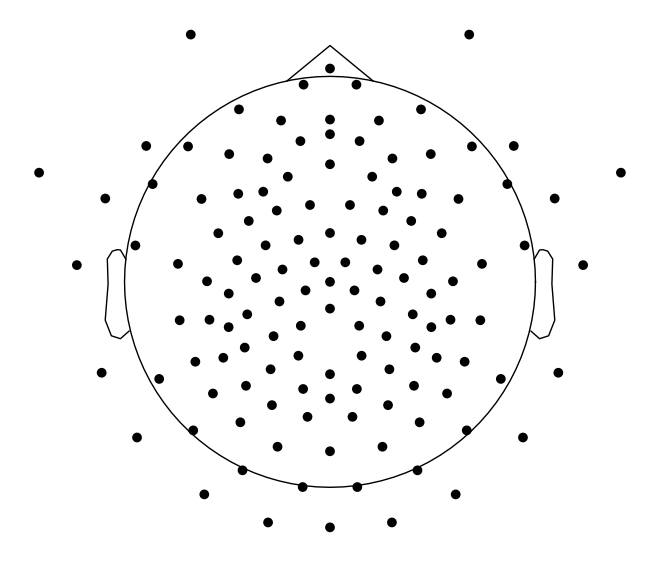

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    0.8s finished


Executing RANSAC
This may take a while, so be patient...
Progress: 10%... 20%... 30%... 40%... 50%... 60%... 70%... 80%... 90%... 100%

RANSAC done!
Interpolating bad channels
    Automatic origin fit: head of radius 78.3 mm
Computing interpolation matrix from 113 sensor positions
Interpolating 16 sensors
Creating RawArray with float64 data, n_channels=63, n_times=262609
    Range : 0 ... 262608 =      0.000 ...   525.216 secs
Ready.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.25
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.00 Hz)
- Upper passband edge: 50.75 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 51.00 Hz)
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)



[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.3s finished


Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 46 events and 1350 original time points ...
0 bad epochs dropped
Effective window size : 5.000 (s)


 88%|████████████████████████████████████████████████████████████████████████████████████████████▊             | 7/8 [04:33<00:41, 41.20s/it]

Creating RawArray with float64 data, n_channels=129, n_times=226505
    Range : 0 ... 226504 =      0.000 ...   453.008 secs
Ready.


/u/home/swth/brain-age/drafts/schwarz/../../src/utils/format_hbn.py:65: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info.set_montage(self.montage_hbn)


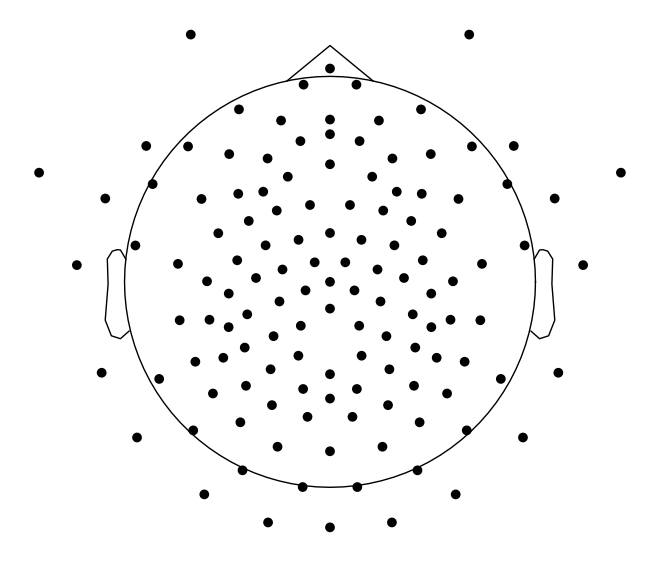

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    0.6s finished


Executing RANSAC
This may take a while, so be patient...
Progress: 10%... 20%... 30%... 40%... 50%... 60%... 70%... 80%... 90%... 100%

RANSAC done!
Interpolating bad channels
    Automatic origin fit: head of radius 78.3 mm
Computing interpolation matrix from 116 sensor positions
Interpolating 13 sensors
Creating RawArray with float64 data, n_channels=63, n_times=226505
    Range : 0 ... 226504 =      0.000 ...   453.008 secs
Ready.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.25
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.00 Hz)
- Upper passband edge: 50.75 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 51.00 Hz)
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)



[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.3s finished


Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 39 events and 1350 original time points ...
0 bad epochs dropped
Effective window size : 5.000 (s)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [05:18<00:00, 39.77s/it]


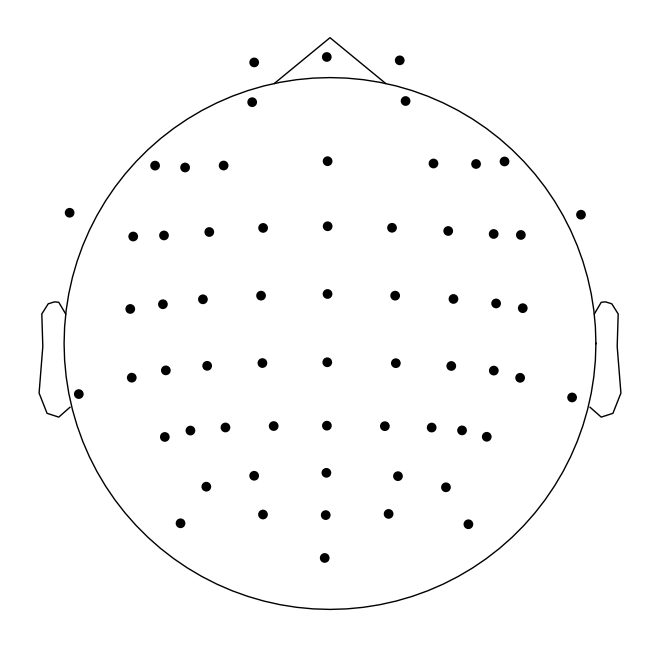

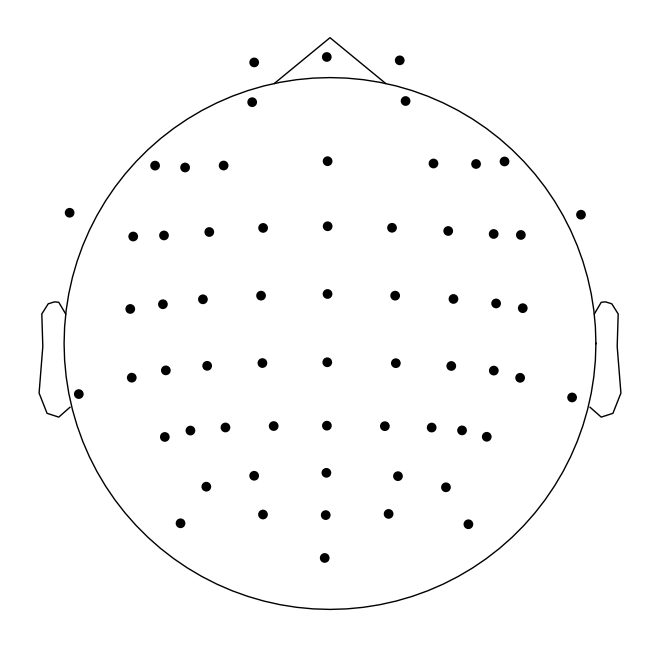

In [104]:
psds_hbn = []
for f in tqdm.tqdm(eeg_files_hbn[:n_files]):
    
    ### load hbn files into a raw object with the same meta-data as a raw object of bap
    raw = format_hbn(f)

    ### preprocess
    if raw.tmax <= 60:
        continue
    raw = raw.crop(raw.tmin+30, raw.tmax-30)
    raw = raw.notch_filter(freqs=50, notch_widths=0.5)
    raw = raw.filter(l_freq=l_freq, h_freq=h_freq)
    raw = raw.resample(sfreq=sfreq)

    ### align
    raw._data = channelwise_norm(raw._data)
    raw._data = totensor(raw._data)
    raw._data = clamp(raw._data)
    raw._data = raw._data.numpy()

    ### extract power spectral density
    epochs = mne.make_fixed_length_epochs(raw, duration=10, preload=True)
    epochs_psds = np.log(epochs.compute_psd("welch", fmin=1, fmax=sfreq//2, n_fft=int(5*sfreq)))
    psds_hbn.append(epochs_psds)

### ensure channel locations are the same across hbn and bap
raw.plot_sensors(ch_type='eeg')


  0%|                                                                                                                  | 0/8 [00:00<?, ?it/s]/tmp/ipykernel_121860/3893309714.py:5: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.25
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.00 Hz)
- Upper passband edge: 50.75 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 51.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_121860/3893309714.py:5: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(f, verbose=False, preload=True)
/tmp/ipykernel_121860/3893309714.py:7: RuntimeWarning: The unit for channel(s) AF3, AF4, C1, C2, C3, C4, C5, C6, CP1, CP2, CP3, CP4, CP5, CP6, CPz, Cz, F3, F4, F5, F6, F7, F8, FC1, FC2, FC3, FC4, FC5, FC6, FT10, FT7

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)



[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.3s finished


Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 24 events and 1350 original time points ...
3 bad epochs dropped
Effective window size : 5.000 (s)


 12%|█████████████▎                                                                                            | 1/8 [00:01<00:09,  1.42s/it]/tmp/ipykernel_121860/3893309714.py:5: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.25
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.00 Hz)
- Upper passband edge: 50.75 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 51.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_121860/3893309714.py:5: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(f, verbose=False, preload=True)
/tmp/ipykernel_121860/3893309714.py:7: RuntimeWarning: The unit for channel(s) AF3, AF4, C1, C2, C3, C4, C5, C6, CP1, CP2, CP3, CP4, CP5, CP6, CPz, Cz, F3, F4, F5, F6, F7, F8, FC1, FC2, FC3, FC4, FC5, FC6, FT10, FT7

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)



[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.3s finished


Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 24 events and 1350 original time points ...
1 bad epochs dropped
Effective window size : 5.000 (s)


 25%|██████████████████████████▌                                                                               | 2/8 [00:02<00:08,  1.45s/it]/tmp/ipykernel_121860/3893309714.py:5: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.25
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.00 Hz)
- Upper passband edge: 50.75 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 51.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_121860/3893309714.py:5: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(f, verbose=False, preload=True)
/tmp/ipykernel_121860/3893309714.py:7: RuntimeWarning: The unit for channel(s) AF3, AF4, C1, C2, C3, C4, C5, C6, CP1, CP2, CP3, CP4, CP5, CP6, CPz, Cz, F3, F4, F5, F6, F7, F8, FC1, FC2, FC3, FC4, FC5, FC6, FT10, FT7

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)



[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.3s finished


Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 24 events and 1350 original time points ...
0 bad epochs dropped
Effective window size : 5.000 (s)


 38%|███████████████████████████████████████▊                                                                  | 3/8 [00:04<00:07,  1.44s/it]/tmp/ipykernel_121860/3893309714.py:5: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.25
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.00 Hz)
- Upper passband edge: 50.75 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 51.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_121860/3893309714.py:5: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(f, verbose=False, preload=True)
/tmp/ipykernel_121860/3893309714.py:7: RuntimeWarning: The unit for channel(s) AF3, AF4, C1, C2, C3, C4, C5, C6, CP1, CP2, CP3, CP4, CP5, CP6, CPz, Cz, F3, F4, F5, F6, F7, F8, FC1, FC2, FC3, FC4, FC5, FC6, FT10, FT7

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)



[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.3s finished


Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 24 events and 1350 original time points ...
6 bad epochs dropped
Effective window size : 5.000 (s)


 50%|█████████████████████████████████████████████████████                                                     | 4/8 [00:05<00:05,  1.44s/it]/tmp/ipykernel_121860/3893309714.py:5: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.25
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.00 Hz)
- Upper passband edge: 50.75 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 51.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_121860/3893309714.py:5: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(f, verbose=False, preload=True)
/tmp/ipykernel_121860/3893309714.py:7: RuntimeWarning: The unit for channel(s) AF3, AF4, C1, C2, C3, C4, C5, C6, CP1, CP2, CP3, CP4, CP5, CP6, CPz, Cz, F3, F4, F5, F6, F7, F8, FC1, FC2, FC3, FC4, FC5, FC6, FT10, FT7

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)



[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.3s finished


Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 24 events and 1350 original time points ...
6 bad epochs dropped
Effective window size : 5.000 (s)


 62%|██████████████████████████████████████████████████████████████████▎                                       | 5/8 [00:07<00:04,  1.43s/it]/tmp/ipykernel_121860/3893309714.py:5: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.25
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.00 Hz)
- Upper passband edge: 50.75 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 51.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_121860/3893309714.py:5: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(f, verbose=False, preload=True)
/tmp/ipykernel_121860/3893309714.py:7: RuntimeWarning: The unit for channel(s) AF3, AF4, C1, C2, C3, C4, C5, C6, CP1, CP2, CP3, CP4, CP5, CP6, CPz, Cz, F3, F4, F5, F6, F7, F8, FC1, FC2, FC3, FC4, FC5, FC6, FT10, FT7

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)



[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.3s finished


Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 24 events and 1350 original time points ...
8 bad epochs dropped
Effective window size : 5.000 (s)


 75%|███████████████████████████████████████████████████████████████████████████████▌                          | 6/8 [00:08<00:02,  1.42s/it]/tmp/ipykernel_121860/3893309714.py:5: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.25
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.00 Hz)
- Upper passband edge: 50.75 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 51.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_121860/3893309714.py:5: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(f, verbose=False, preload=True)
/tmp/ipykernel_121860/3893309714.py:7: RuntimeWarning: The unit for channel(s) AF3, AF4, C1, C2, C3, C4, C5, C6, CP1, CP2, CP3, CP4, CP5, CP6, CPz, Cz, F3, F4, F5, F6, F7, F8, FC1, FC2, FC3, FC4, FC5, FC6, FT10, FT7

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)



[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.3s finished


Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 24 events and 1350 original time points ...
2 bad epochs dropped
Effective window size : 5.000 (s)


 88%|████████████████████████████████████████████████████████████████████████████████████████████▊             | 7/8 [00:10<00:01,  1.42s/it]/tmp/ipykernel_121860/3893309714.py:5: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.25
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.00 Hz)
- Upper passband edge: 50.75 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 51.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_121860/3893309714.py:5: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(f, verbose=False, preload=True)
/tmp/ipykernel_121860/3893309714.py:7: RuntimeWarning: The unit for channel(s) AF3, AF4, C1, C2, C3, C4, C5, C6, CP1, CP2, CP3, CP4, CP5, CP6, CPz, Cz, F3, F4, F5, F6, F7, F8, FC1, FC2, FC3, FC4, FC5, FC6, FT10, FT7

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)



[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.3s finished


Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 24 events and 1350 original time points ...
0 bad epochs dropped
Effective window size : 5.000 (s)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:11<00:00,  1.43s/it]


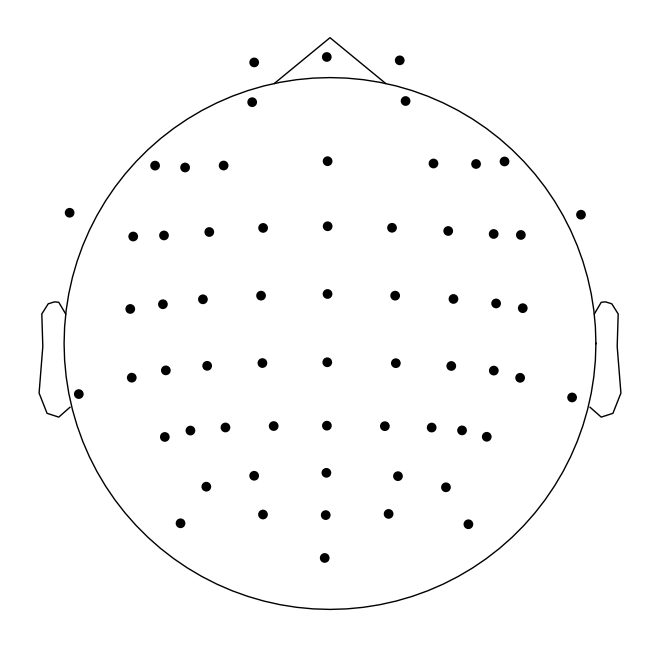

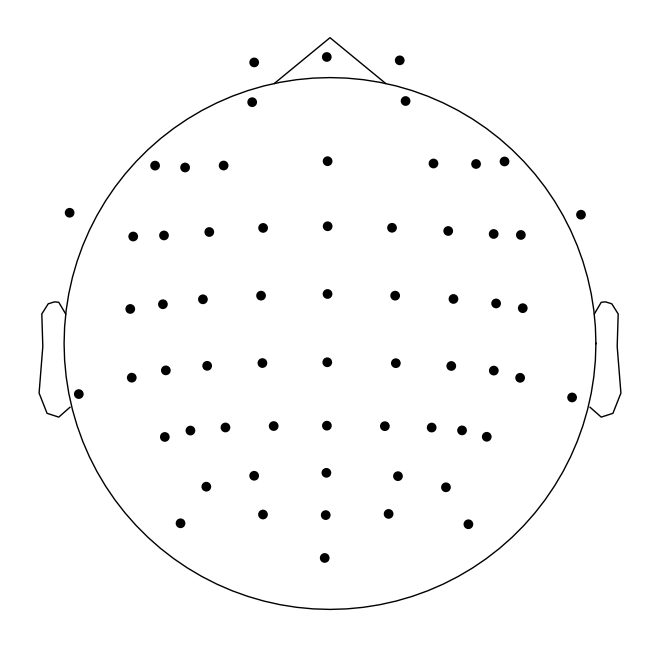

In [105]:
psds_bap = []
for f in tqdm.tqdm(eeg_files_bap[:n_files]):
    
    ### load bap files into a raw object
    raw = mne.io.read_raw_brainvision(f, verbose=False, preload=True)
    
    raw.set_channel_types(channel_to_channel_type)
    raw.set_montage(montage_bap)
    
    ### preprocess
    raw = raw.crop(raw.tmin+30, raw.tmax-30)
    raw = raw.notch_filter(freqs=50, notch_widths=0.5)
    raw = raw.filter(l_freq=l_freq, h_freq=h_freq)
    raw = raw.resample(sfreq=sfreq)

    ### align
    raw._data = channelwise_norm(raw._data)
    raw._data = totensor(raw._data)
    raw._data = clamp(raw._data)
    raw._data = raw._data.numpy()

    ### extract power spectral density
    epochs = mne.make_fixed_length_epochs(raw, duration=10, preload=True)
    epochs_psds = np.log(epochs.compute_psd("welch", fmin=1, fmax=sfreq//2, n_fft=int(5*sfreq)))
    psds_bap.append(epochs_psds)

### ensure channel locations are the same across hbn and bap
raw.plot_sensors(ch_type='eeg')

### Check for data drift in the frequency domain

In [106]:
psds_hbn_ = np.concatenate(psds_hbn)
psds_bap_ = np.concatenate(psds_bap)
# psds_hbn_ = psds_hbn_ / psds_hbn_.sum(axis=(1,2), keepdims=True) 
# psds_bap_ = psds_bap_ / psds_bap_.sum(axis=(1,2), keepdims=True) 

In [107]:
psds = np.concatenate([psds_hbn_, psds_bap_])
np.random.seed(42)
pca = PCA(n_components=32, whiten=True)
assert len(psds_hbn_)+len(psds_bap_)==len(psds)
psds_pcs = pca.fit_transform(psds.reshape(len(psds), -1))
median_hbn_psds_pcs = np.median(psds_pcs[:len(psds_hbn_), :], axis=0)
median_bap_psds_pcs = np.median(psds_pcs[len(psds_hbn_):, :], axis=0)

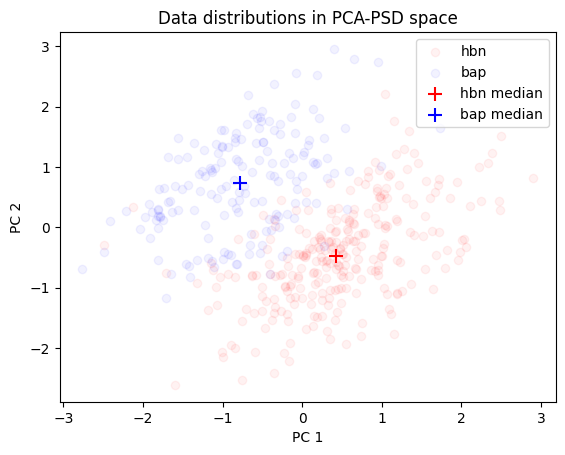

In [108]:
plt.title("Data distributions in PCA-PSD space")
plt.scatter(psds_pcs[:len(psds_hbn_), 0], psds_pcs[:len(psds_hbn_), 1], c="r", label="hbn", alpha=0.05)
plt.scatter(psds_pcs[len(psds_hbn_):, 0], psds_pcs[len(psds_hbn_):, 1], c="b", label="bap", alpha=0.05)
plt.scatter(median_hbn_psds_pcs[0], median_hbn_psds_pcs[1], c="r", marker="+", s=100, label="hbn median")
plt.scatter(median_bap_psds_pcs[0], median_bap_psds_pcs[1], c="b", marker="+", s=100, label="bap median")

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.show()